In [8]:
from __future__ import print_function
from fenics import *
from mshr import *
from dolfin import *
import numpy as np
import sys

T = 10.0            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
k = Constant(dt)

# CF params
beta = 2.2
b = 1.
n = 1.0
dc = 9e-5
df = 9e-1
q = 4.48e-0
mu = 0.01312
_lambda = 0.01312
eta = 10.54
Dc = 1.32e-8
Df = 1.32e-2
Dw = 1.32e-3
w_r = 1.0

beta = Constant(beta)
b = Constant(b)
n = Constant(n)
dc = Constant(dc)
df = Constant(df)
q = Constant(q)
mu = Constant(mu)
_lambda = Constant(_lambda)
eta = Constant(eta)
Dc = Constant(Dc)
Df = Constant(Df)
Dw = Constant(Dw)
w_r = Constant(w_r)

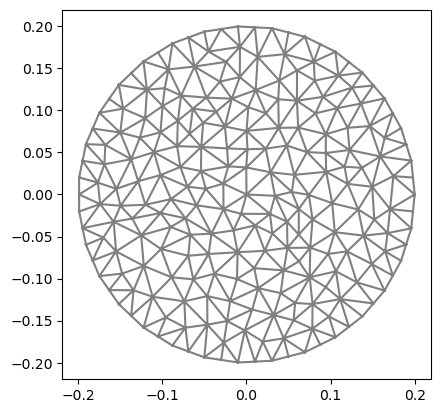

In [9]:
# Read mesh from file
# mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')
L = .2
nx = ny = 10
# mesh = RectangleMesh(Point(-L, -L), Point(L, L), nx, ny)
domain = Circle(Point(0, 0), L)

mesh = generate_mesh(domain, nx)
plot(mesh)

In [11]:
# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
u = Function(V)
u_n = Function(V)

# Guasian ICs for C and F
u_0 = Expression(('0.1*exp(-100*pow(x[0], 2) - 100*pow(x[1], 2))','0.4*exp(-100*pow(x[0], 2) - 100*pow(x[1], 2))','0.1'), degree = 2, L=L)
u_n = interpolate(u_0, V)

# # Constant initial conditions for checking against ODE
# u_0 = Expression(('0.4','0.3','0.1'), degree = 2)
# u_n = interpolate(u_0, V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.4,2)+pow(x[1]-0.4,2)<0.05*0.05 ? 0.5 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.5 : 0',
                 degree=1)
f_3 = Constant(0)


# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx  \
  + Dc*dot(grad(u_1), grad(v_1))*dx - (beta/( b + u_3 ))*u_3*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx  \
  + Df*dot(grad(u_2), grad(v_2))*dx - beta*(1 - u_3/( b + u_3 ))*u_2*(1-u_1-u_2)*v_2*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx  \
  + Dw*dot(grad(u_3), grad(v_3))*dx - _lambda*v_3*dx + eta*u_1*u_3*v_3*dx + mu*u_3*v_3*dx

# # Define variational problem
# F = ((u_1 - u_n1) / k)*v_1*dx  \
#   + Dc*dot(grad(u_1), grad(v_1))*dx - (pow(beta,n)/( pow(b,n) + pow(u_3,n) ))*pow(u_3,n)*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
#   + ((u_2 - u_n2) / k)*v_2*dx  \
#   + Df*dot(grad(u_2), grad(v_2))*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  - pow(beta,n)*(1 - pow(u_3,n)/( pow(b,n) + pow(u_3,n) ))*u_2*(1-u_1-u_2)*v_2*dx  \
#   + ((u_3 - u_n3) / k)*v_3*dx  \
#   + Dw*dot(grad(u_3), grad(v_3))*dx - _lambda*v_3*dx + mu*u_3*v_3*dx + eta*u_1*u_3*v_3*dx



# Create VTK files for visualization output
vtkfile_u_1 = File('cf_sys/u_1.pvd')
vtkfile_u_2 = File('cf_sys/u_2.pvd')
vtkfile_u_3 = File('cf_sys/u_3.pvd')

# Create progress bar
# progress = Progress('Time-stepping')
# set_log_level(PROGRESS)
progress = Progress('Time-stepping', num_steps)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    # timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    set_log_level(LogLevel.PROGRESS)
    progress += 1

# Hold plot
#interactive()

### write out function values for anaerobic population
u_1, u_2, u_3 = split(u)


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.992e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.633e-03 (tol = 1.000e-10) r (rel) = 2.044e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 6.136e-07 (tol = 1.000e-10) r (rel) = 7.678e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.870e-14 (tol = 1.000e-10) r (rel) = 8.596e-13 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.360e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 6

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.452e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 4.539e-08 (tol = 1.000e-10) r (rel) = 7.035e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.878e-16 (tol = 1.000e-10) r (rel) = 2.912e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [==>                                                    ] 4.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.164e-04 

  Newton iteration 0: r (abs) = 4.942e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.656e-08 (tol = 1.000e-10) r (rel) = 3.352e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.946e-17 (tol = 1.000e-10) r (rel) = 5.961e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [====>                                                  ] 8.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.955e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.122e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.499e-08 (tol = 1.000e-10) r (rel) = 2.926e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.323e-17 (tol = 1.000e-10) r (rel) = 4.534e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.140e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

  Newton iteration 0: r (abs) = 5.321e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.574e-08 (tol = 1.000e-10) r (rel) = 2.958e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.341e-17 (tol = 1.000e-10) r (rel) = 4.399e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.336e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.569e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.846e-08 (tol = 1.000e-10) r (rel) = 3.315e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.782e-17 (tol = 1.000e-10) r (rel) = 4.996e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [=========>                                             ] 17.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.576e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  

Time-stepping [===========>                                           ] 20.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.630e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.972e-08 (tol = 1.000e-10) r (rel) = 3.504e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 3.144e-17 (tol = 1.000e-10) r (rel) = 5.585e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear 

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.595e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 2.000e-08 (tol = 1.000e-10) r (rel) = 3.574e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 3.301e-17 (tol = 1.000e-10) r (rel) = 5.900e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.589e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear syst

  Newton iteration 0: r (abs) = 5.468e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.943e-08 (tol = 1.000e-10) r (rel) = 3.553e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 3.153e-17 (tol = 1.000e-10) r (rel) = 5.767e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.457e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.122e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.719e-08 (tol = 1.000e-10) r (rel) = 3.356e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.924e-17 (tol = 1.000e-10) r (rel) = 5.709e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.104e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.844e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.533e-08 (tol = 1.000e-10) r (rel) = 3.164e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.359e-17 (tol = 1.000e-10) r (rel) = 4.870e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.822e-04 (tol = 1.000e-1

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.532e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.331e-08 (tol = 1.000e-10) r (rel) = 2.937e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 2.298e-17 (tol = 1.000e-10) r (rel) = 5.070e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.509e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.154e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.103e-08 (tol = 1.000e-10) r (rel) = 2.654e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.786e-17 (tol = 1.000e-10) r (rel) = 4.298e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.130e-04 (tol = 1.000e-1

  Newton iteration 0: r (abs) = 3.868e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 9.423e-09 (tol = 1.000e-10) r (rel) = 2.436e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.611e-17 (tol = 1.000e-10) r (rel) = 4.166e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.844e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.540e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 7.738e-09 (tol = 1.000e-10) r (rel) = 2.186e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.649e-17 (tol = 1.000e-10) r (rel) = 4.658e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.517e-04 (tol = 1.000e-1

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.270e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 6.477e-09 (tol = 1.000e-10) r (rel) = 1.980e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.518e-17 (tol = 1.000e-10) r (rel) = 4.643e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.248e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear syst

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.913e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 4.983e-09 (tol = 1.000e-10) r (rel) = 1.711e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.496e-17 (tol = 1.000e-10) r (rel) = 5.135e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.893e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.682e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 4.124e-09 (tol = 1.000e-10) r (rel) = 1.538e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.576e-17 (tol = 1.000e-10) r (rel) = 5.875e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.663e-04 (tol = 1.000e-1

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.468e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 3.408e-09 (tol = 1.000e-10) r (rel) = 1.381e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.533e-17 (tol = 1.000e-10) r (rel) = 6.211e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.451e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.273e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 2.817e-09 (tol = 1.000e-10) r (rel) = 1.239e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.631e-17 (tol = 1.000e-10) r (rel) = 7.177e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.258e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.947e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.970e-09 (tol = 1.000e-10) r (rel) = 1.011e-05 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.570e-17 (tol = 1.000e-10) r (rel) = 8.062e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.935e-04 (tol = 1.000e-1

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.789e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.620e-09 (tol = 1.000e-10) r (rel) = 9.054e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.510e-17 (tol = 1.000e-10) r (rel) = 8.440e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.778e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.648e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.341e-09 (tol = 1.000e-10) r (rel) = 8.140e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.654e-17 (tol = 1.000e-10) r (rel) = 1.004e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.638e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

  Newton iteration 0: r (abs) = 1.504e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 1.089e-09 (tol = 1.000e-10) r (rel) = 7.245e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.607e-17 (tol = 1.000e-10) r (rel) = 1.069e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.495e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.385e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 9.061e-10 (tol = 1.000e-10) r (rel) = 6.544e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.504e-17 (tol = 1.000e-10) r (rel) = 1.086e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.377e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.279e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 7.613e-10 (tol = 1.000e-10) r (rel) = 5.953e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.450e-17 (tol = 1.000e-10) r (rel) = 1.134e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.272e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.123e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 5.785e-10 (tol = 1.000e-10) r (rel) = 5.149e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.614e-17 (tol = 1.000e-10) r (rel) = 1.437e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.117e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear syst

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.019e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 4.748e-10 (tol = 1.000e-10) r (rel) = 4.659e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.555e-17 (tol = 1.000e-10) r (rel) = 1.525e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.014e-04 (tol = 1.000e-1

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.329e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 3.997e-10 (tol = 1.000e-10) r (rel) = 4.285e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.575e-17 (tol = 1.000e-10) r (rel) = 1.688e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.284e-05 (tol = 1.000e-1

  Newton iteration 0: r (abs) = 8.810e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 3.589e-10 (tol = 1.000e-10) r (rel) = 4.074e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.566e-17 (tol = 1.000e-10) r (rel) = 1.778e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.769e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.331e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 3.240e-10 (tol = 1.000e-10) r (rel) = 3.889e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.560e-17 (tol = 1.000e-10) r (rel) = 1.873e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.293e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.887e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 2.938e-10 (tol = 1.000e-10) r (rel) = 3.725e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.536e-17 (tol = 1.000e-10) r (rel) = 1.948e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.852e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Kr

  Newton iteration 0: r (abs) = 7.508e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 1: r (abs) = 2.697e-10 (tol = 1.000e-10) r (rel) = 3.592e-06 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678 system.
  Newton iteration 2: r (abs) = 1.686e-17 (tol = 1.000e-10) r (rel) = 2.246e-13 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.474e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 678 x 678 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 678 x 678

Object cannot be plotted directly, projecting to piecewise linears.
Solving linear system of size 226 x 226 (PETSc LU solver, umfpack).
PETSc Krylov solver starting to solve 226 x 226 system.


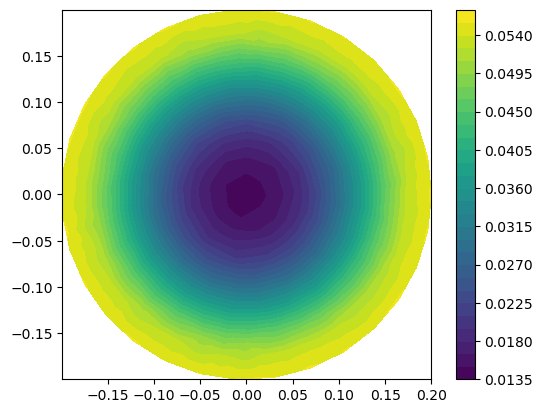

In [41]:
h = plot(u[2])
plt.colorbar(h)

In [25]:
c = u[0]

In [29]:
c([L,0])

0.0059789240703186355

In [31]:
L

0.2

In [33]:
c([0,L/2])

0.07289685889667066